In [9]:
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
import pandas as pd
from random import sample
import matplotlib.pyplot as plt

Problem 1 Question 1, 2

In [ ]:

#Train and test data
mnist_train=torchvision.datasets.MNIST('mnist',
                                       train=True,
                                       download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
                                       ]))


mnist_= torchvision.datasets.MNIST('mnist',
                          train=False,
                          download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,))
                          ])
                          )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [ ]:
batch_size = 64

#creating a dataloader
train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
test_dataloader = DataLoader(mnist_, batch_size=batch_size)

#Testing the size of each input
print(len(test_dataloader))
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

157
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
#use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 1024)
        self.l4 = nn.Linear(1024, 1024)
        self.l5 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.flatten(x)
        # print(x.shape)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.l5(x)
        
        return x


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    pred_y_all = torch.Tensor()
    org_y = torch.Tensor()
    input_x = torch.Tensor()
    size = len(dataloader.dataset)
    m = nn.Softmax(dim=1)
    num_batches = len(dataloader)

    model.eval()

    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = m(pred)
            pred_y = pred.argmax(1)
            correct += (pred_y == y).type(torch.float).sum().item()

            pred_y_all = pred_y_all.to(device)
            pred_y_all = torch.cat((pred_y_all, pred_y))

            org_y = org_y.to(device)
            org_y = torch.cat((org_y, y))

            input_x = input_x.to(device)
            input_x = torch.cat((input_x, X))

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return pred_y_all, org_y, input_x



model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    #predicted y, original y, input
    pred_y_all, org_y, input_x = test(test_dataloader, model, loss_fn)
    
print("Done!")


Epoch 1
-------------------------------
loss: 2.304091  [    0/60000]
loss: 2.279507  [ 6400/60000]
loss: 2.258713  [12800/60000]
loss: 2.152151  [19200/60000]
loss: 1.924527  [25600/60000]
loss: 1.305260  [32000/60000]
loss: 0.795127  [38400/60000]
loss: 0.703937  [44800/60000]
loss: 0.566367  [51200/60000]
loss: 0.528451  [57600/60000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.452988 

Epoch 2
-------------------------------
loss: 0.480170  [    0/60000]
loss: 0.306117  [ 6400/60000]
loss: 0.355305  [12800/60000]
loss: 0.382713  [19200/60000]
loss: 0.326228  [25600/60000]
loss: 0.321308  [32000/60000]
loss: 0.215062  [38400/60000]
loss: 0.357669  [44800/60000]
loss: 0.341120  [51200/60000]
loss: 0.352403  [57600/60000]
Test Error: 
 Accuracy: 91.2%, Avg loss: 0.286969 

Epoch 3
-------------------------------
loss: 0.199287  [    0/60000]
loss: 0.203641  [ 6400/60000]
loss: 0.192274  [12800/60000]
loss: 0.323253  [19200/60000]
loss: 0.216367  [25600/60000]
loss: 0.259623  [32000/600

Problem 1, qns 3:

In [1]:
def plot_images(df_groups, column, row, fig_name):
    j = 0
    k = 0

    fig, ax = plt.subplots(row, column, figsize=(22, 14), sharex=True)

    for i, loop in enumerate(df_groups):
        for indexes in loop[1]['indices']:
            if k == row:
                break

            new_ax = ax[k, j]

            new_ax.imshow(input_x[indexes].to('cpu').squeeze(0))

            if j == (column - 1):
                j = 0
                k = k + 1

            else:
                j = j + 1

        fig.savefig(f'{fig_name}', facecolor='white', 
                    transparent=False)

        plt.show()

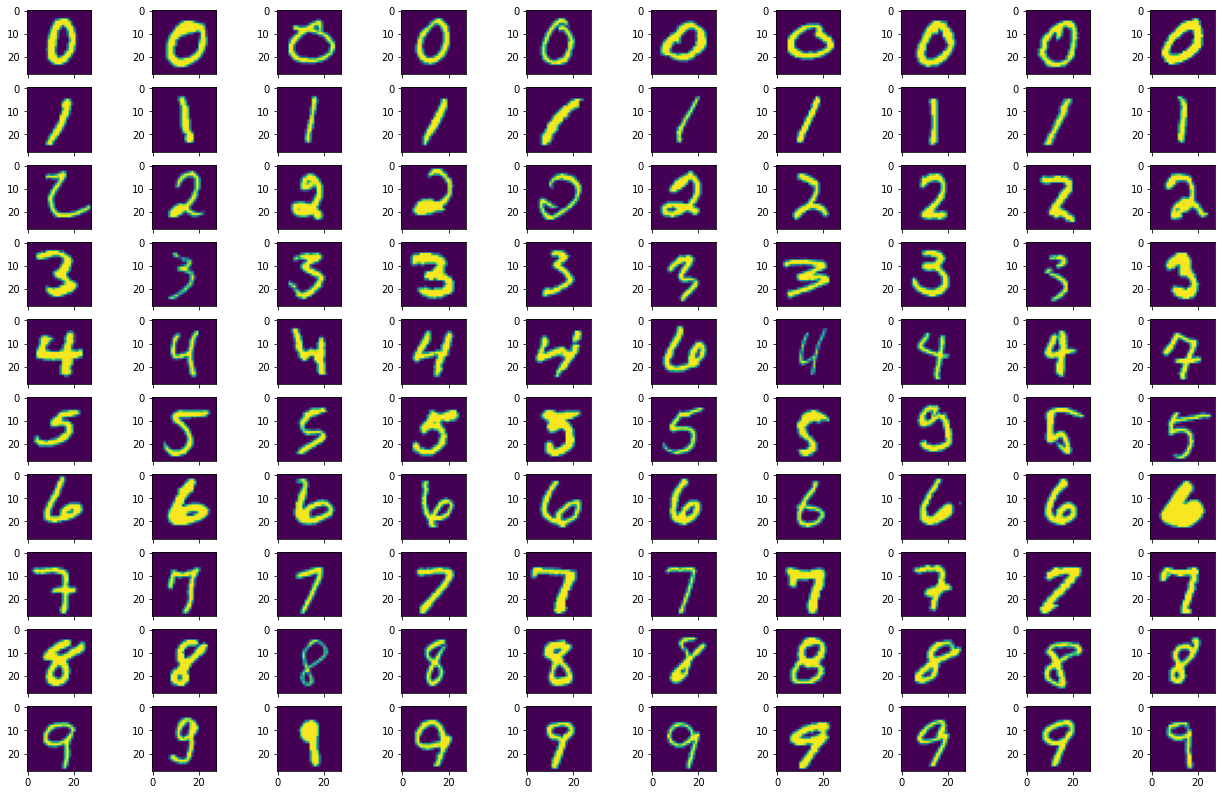

In [ ]:
#create 1000 sample index
index = [i for i in range(input_x.shape[0])]
index_sample = sample(index, 1000)

#dataframe with random sample with original lable, y , predicted label and index
# of random sample
df = pd.DataFrame()
df['indices'] = index_sample

org_y = org_y.to('cpu')
df['org_y'] = [org_y[i].tolist() for i in index_sample]

pred_y_all = pred_y_all.to('cpu')
df['pred_y'] = [pred_y_all[i].tolist() for i in index_sample]
df_group = df.groupby(['pred_y']).head(10).reset_index(drop=True)
df_groups = df_group.groupby(['pred_y'])

fig_name = 'images_10x10.png'
fontsize=12
column = 10
row = 10

plot_images(df_groups, column, row, fig_name)

Problem 1 Question 4:

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for name, module in model.named_children():
    if name == 'flatten':
        continue

    module.register_forward_hook(get_activation(name))

In [ ]:
output = {
    'layer': [],
    'indices': [],
    'label_pred': [],
    'output': []
    }

for x in index_sample:
    y = model(input_x[x])

    for k in activation:
        if k == 'flatten':
              continue

    output_vector = activation[k].tolist()[0]
    value = torch.FloatTensor(sample(output_vector, 10))

    output['indices'].append(x)
    output['layer'].append(k)
    output['label_pred'].append(value.argmax())
    output['output'].append(output_vector)

In [ ]:
#Creates dataframe of output of each layer (index of random sample, layer, predicted label, output (10 random feature from each layer))
df_output = pd.DataFrame.from_dict(output)
print(df_output.head())

  layer  indices label_pred                                             output
0    l1      703  tensor(6)  [0.6962796449661255, -0.6358654499053955, 0.02...
1    l2      703  tensor(9)  [0.4341568946838379, 0.5648108124732971, 1.064...
2    l3      703  tensor(2)  [1.038001537322998, -0.4334019720554352, 0.065...
3    l4      703  tensor(6)  [1.160217523574829, -0.5375059843063354, 0.640...
4    l5      703  tensor(0)  [-3.3515145778656006, 1.2115689516067505, 7.72...


Layer  l1


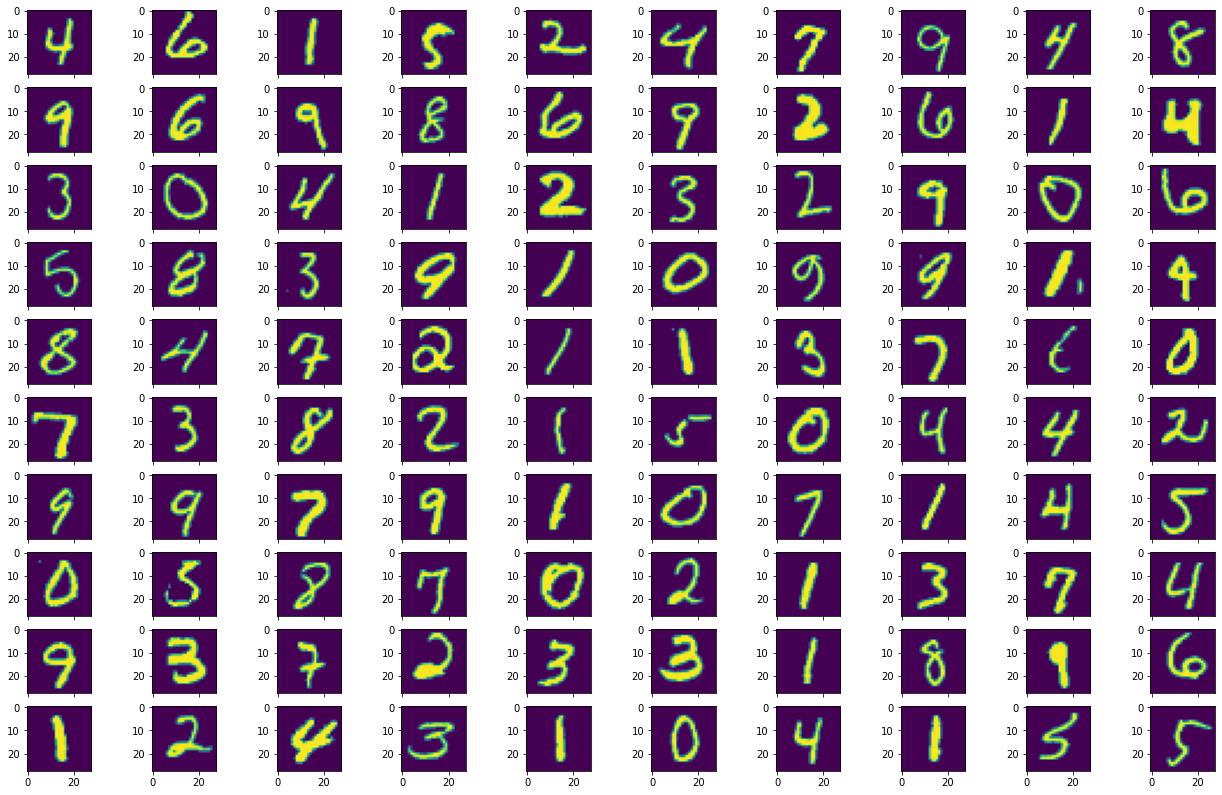

Layer  l2


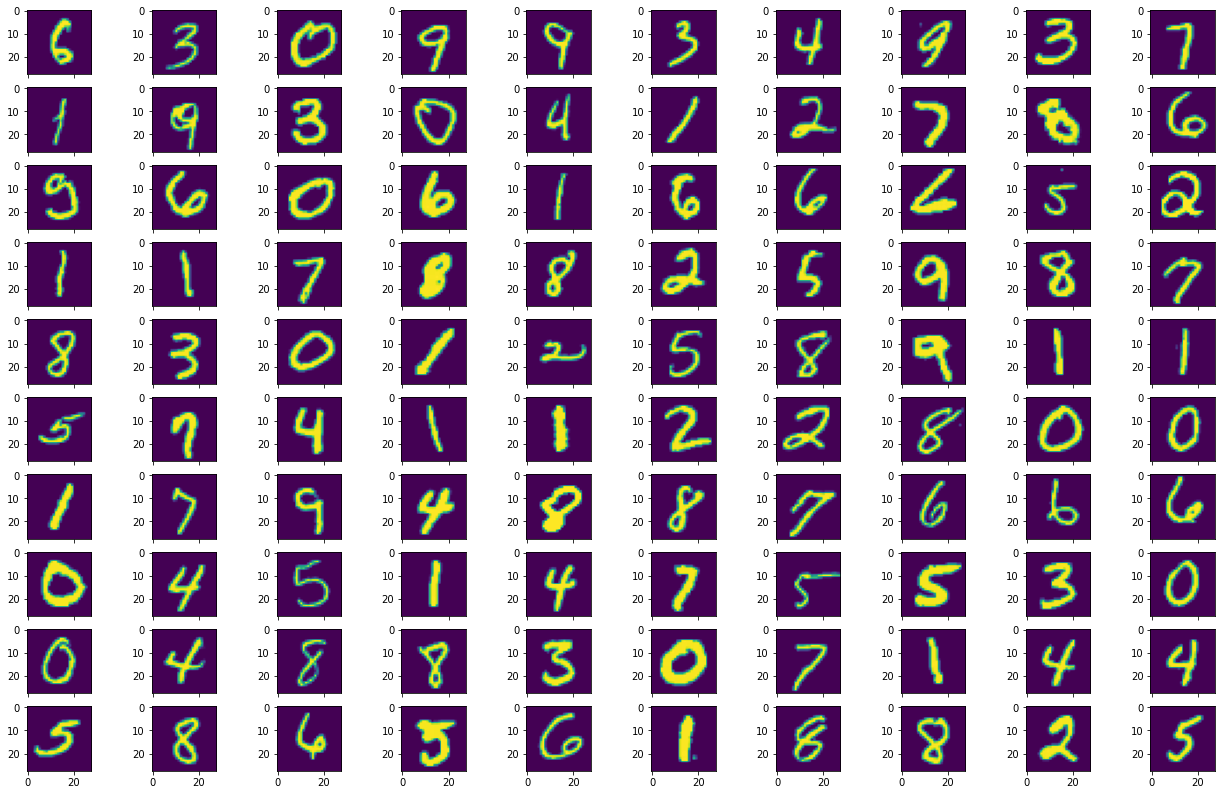

Layer  l3


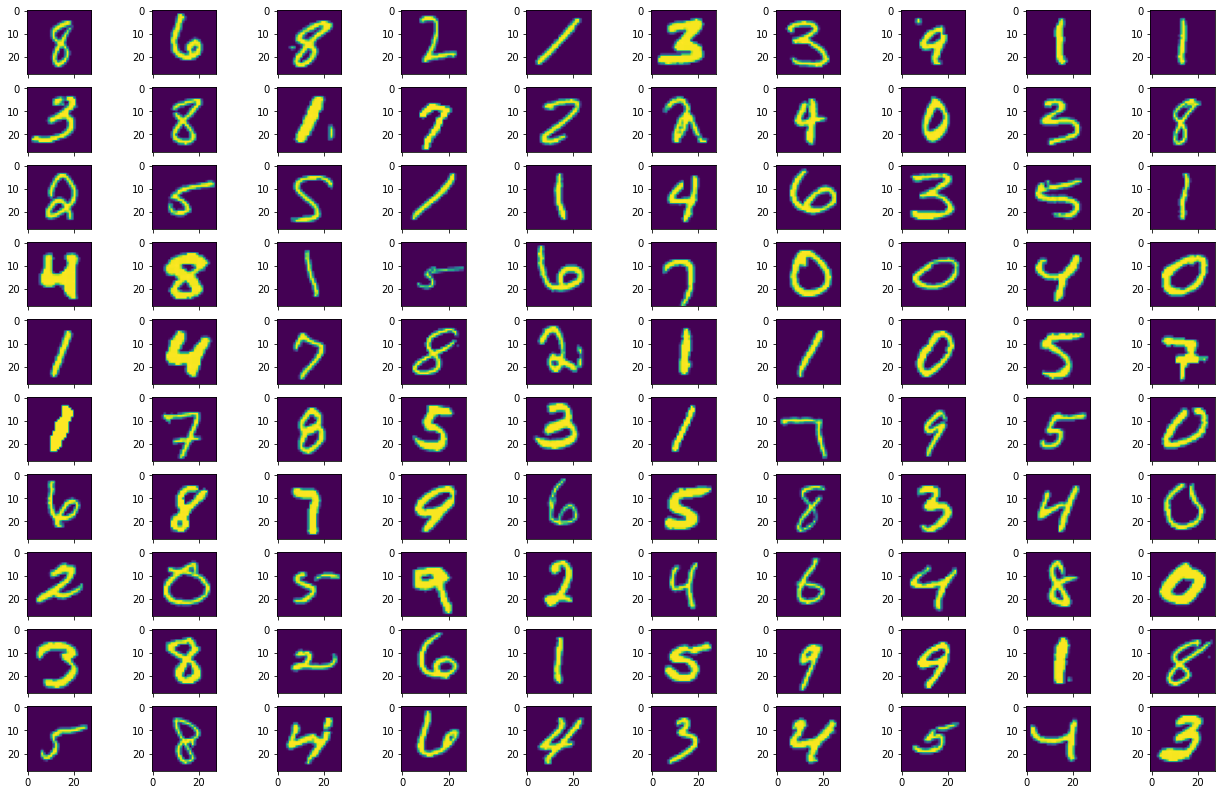

Layer  l4


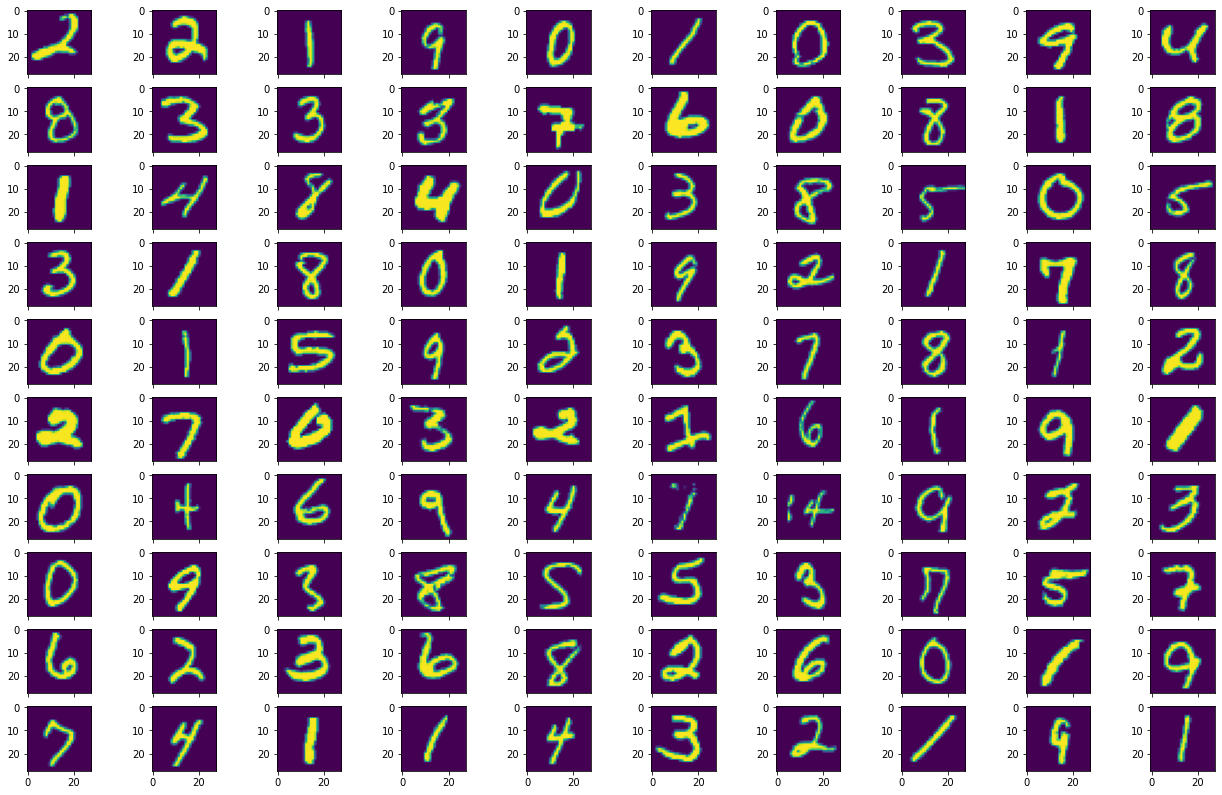

Layer  l5


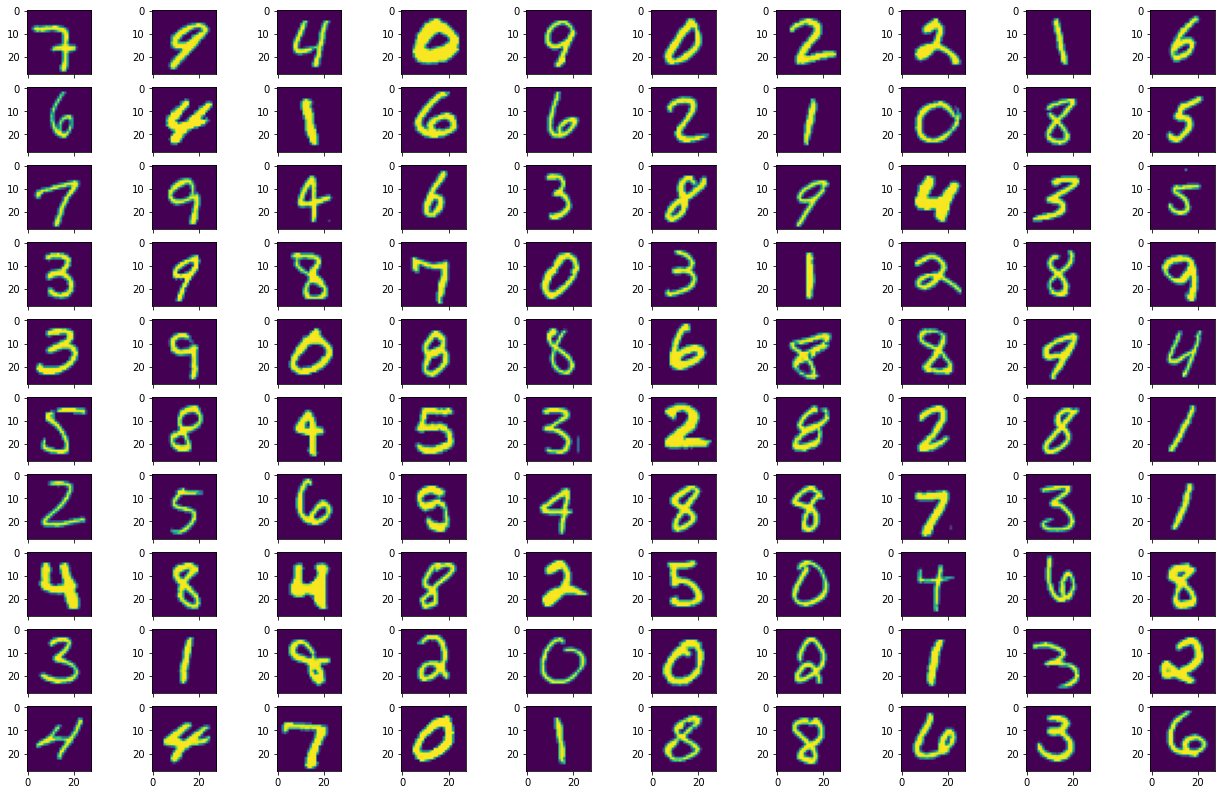

In [ ]:
#plotting the output image associated with maximum value for random 10 features for each layer

df_output_group = df_output.groupby(
    ['layer', 'label_pred']).head(10).reset_index(drop=True)

fig_name = 'qns_4_images_10x10_output.png'
fontsize=12
column = 10
row = 10
df_temp = df_output_group.groupby(['layer'])

for temp in df_temp:
    print('Layer ', temp[0])
  
    df_temp_plot = temp[1].groupby(['label_pred'])
    fig_name = f'qns_4_images_10x10_output_{temp[0]}.png'

    plot_images(df_temp_plot, column, row, fig_name)


We can see that the images associated with the highest value of random 10 features for each layers are very different and do not associate with the correct numbers as compared to problem 1 question 3. This is expected as the layers are capturing features and we can not exactly tell what they are capturing. The numbers are not well separated here in each layers. 



Problem 1 Question : 5 and 6

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

In [14]:
def PCA_visualization(data, y, layer=None):
    pca = PCA(n_components =2)
    pca_output = pca.fit_transform(data)


    df = pd.DataFrame()
    df['pca_1'] = pca_output[:, 0]
    df['pca_2'] = pca_output[:, 1]
    df['y'] = y

    plt.figure(figsize=(7, 7))

    sns.scatterplot(
      x='pca_1',
      y='pca_2',
      hue='y',
      palette=sns.color_palette('hls', 10),
      data=df,
      legend='full',
      # alpha=0.3
    )

    if layer:
        plt.title(f'PCA for layer {layer}')
    else:
        plt.title('PCA visualization')

    plt.show()

In [2]:
def tsne_visualization(data, y, layer=None):
    trans = TSNE(n_components=2, perplexity=40, 
               n_iter=300)
    data_2d = trans.fit_transform(data)

    df = pd.DataFrame()
    df['tsne_1'] = data_2d[:, 0]
    df['tsne_2'] = data_2d[:, 1]
    df['y'] = y
    plt.figure(figsize=(7, 7))

    sns.scatterplot(
      x='tsne_1',
      y='tsne_2',
      hue='y',
      palette=sns.color_palette("hls", 10),
      data=df,
      legend="full",
    )

    if layer:
        plt.title(f'TSNE for layer {layer}')
    else:
        plt.title(f'TSNE visualization')

    plt.show()

In [20]:
#plotting PCA for 1000 random sample input 

flatten = nn.Flatten()
temp = []
y = [org_y[i].tolist() for i in index_sample]

for index in index_sample:
    x = flatten(input_x[index]).tolist()[0]

    temp.append(x)

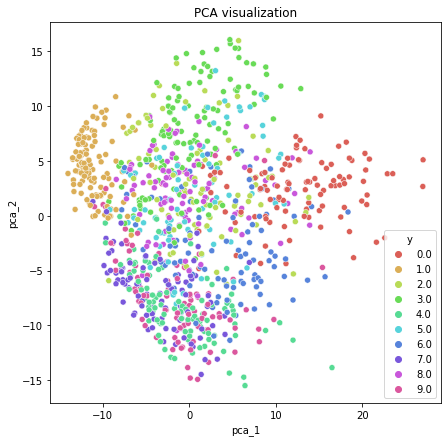

In [17]:
PCA_visualization(temp, y)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


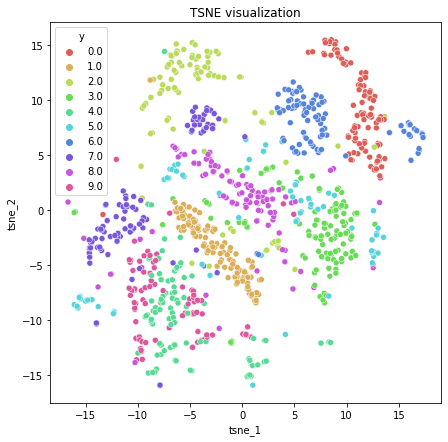

In [24]:
#plotting TSNE for 1000 random sample input 

tsne_visualization(temp, y)

Looking at the TSNE and PCA, the classes are well separated so it should be easy to separate the classes.

Problem 1 Question 7:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


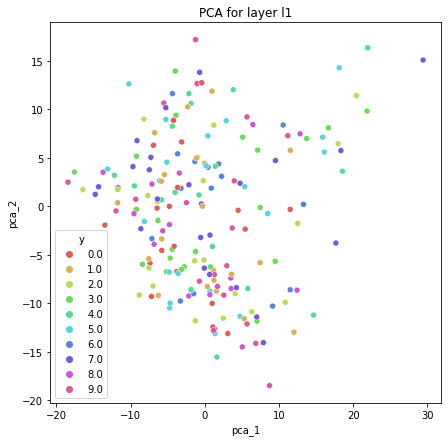

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


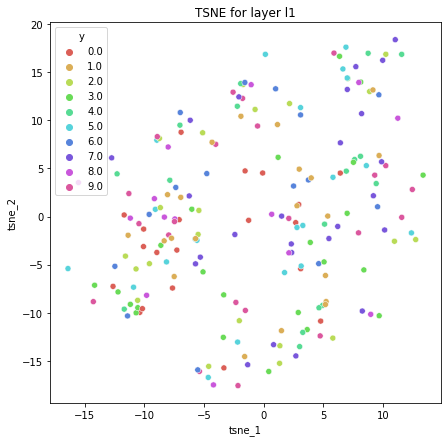

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


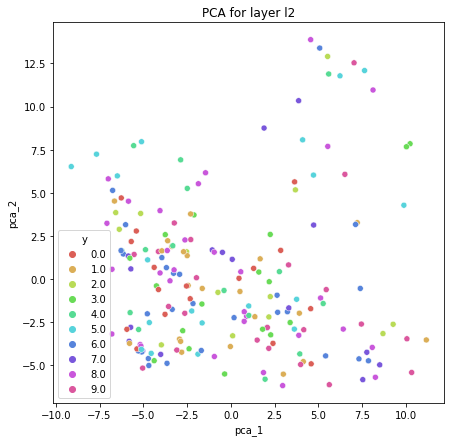

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


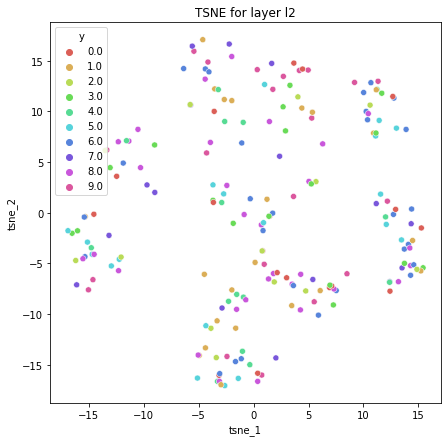

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


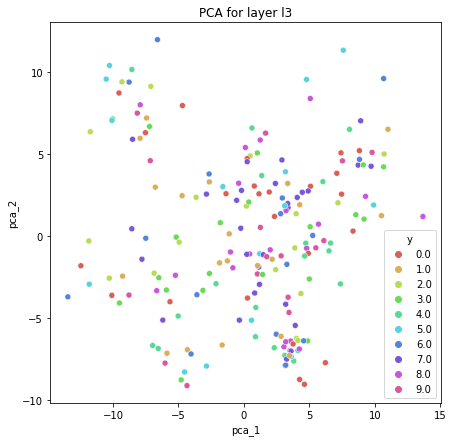

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


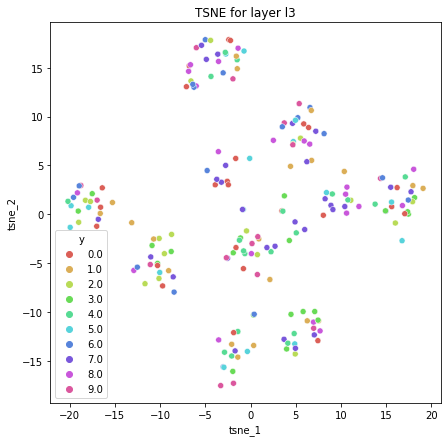

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


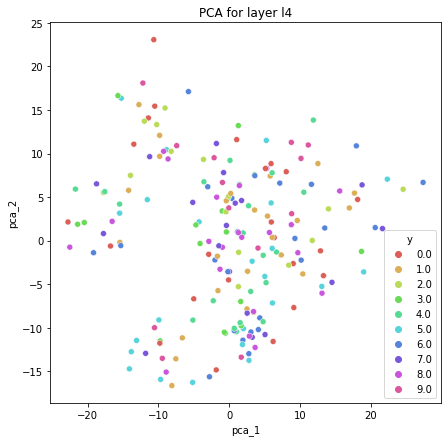

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


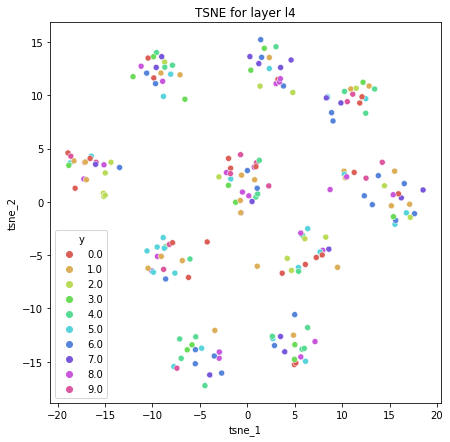

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


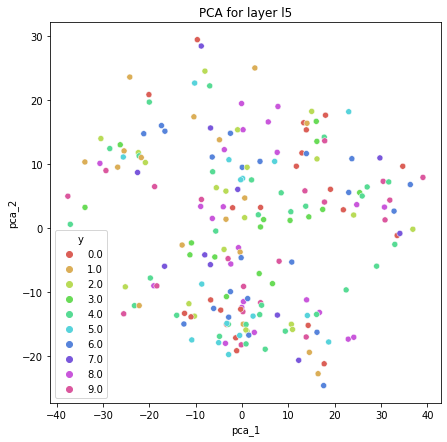

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


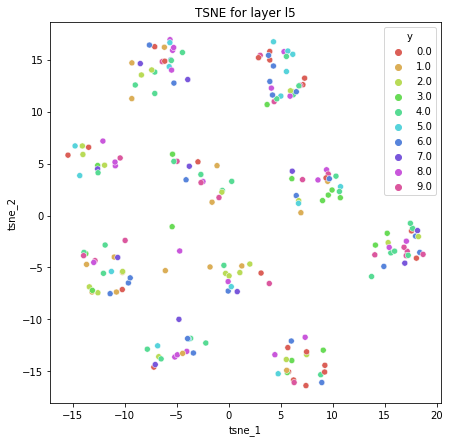

In [25]:
#Getting output of each layer and visualizing the ouput with PCA and TSNE

layers = ['l1', 'l2', 'l3', 'l4', 'l5']

for layer in layers:
    df_layer = df_output.loc[df_output['layer'] == layer]
    df_layer['label_pred'] = df_layer['label_pred'].apply(lambda x: x.tolist())

    PCA_visualization(np.stack(df_layer['output']), df_layer['label_pred'],
                    layer)

    tsne_visualization(np.stack(df_layer['output']), df_layer['label_pred'],
                     layer)

Looking at the PCA plot for each layer, the classes are spread out and not clear.
For TSNE, we can see after each layer there are clusters separating out more and more clearly.

Problem 2: Adult Optimization

In [26]:
class NeuralNetwork_DiffInit(nn.Module):
    def __init__(self, type_init='Logistic:Normal'):
        super(NeuralNetwork_DiffInit, self).__init__()
        
        self.type_init = type_init
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 10)
        print(self.type_init)
        activation = 0
        for key, layer in self.named_children():
            if key == 'flatten':
                continue
            if self.type_init in ['Logistic:Normal', 'ReLU: Normal']:
                nn.init.normal_(layer.weight, mean=0, std=0.01)
            if self.type_init in ['Logistic:Xavier', 'ReLU: Xavier']:
                nn.init.xavier_uniform_(layer.weight)
            if self.type_init == 'ReLU: He':
                nn.init.kaiming_uniform_(layer.weight)


    def forward(self, x):
        x = self.flatten(x)
        
        if self.type_init in ['Logistic:Normal', 'Logistic:Xavier']:
            x = F.sigmoid(self.l1(x))
            x = F.sigmoid(self.l2(x))
            x = F.sigmoid(self.l3(x))
            x = F.sigmoid(self.l4(x))
        
        if self.type_init in ['ReLU: Normal', 'ReLU: Xavier', 'ReLU: He']:
            x = F.relu(self.l1(x))
            x = F.relu(self.l2(x))
            x = F.relu(self.l3(x))
            x = F.relu(self.l4(x))

        return self.l5(x)



def train_init(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_init(dataloader, model, loss_fn):
    pred_y_all = torch.Tensor()
    org_y = torch.Tensor()
    input_x = torch.Tensor()
    size = len(dataloader.dataset)
    m = nn.Softmax(dim=1)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = m(pred)
            pred_y = pred.argmax(1)
            correct += (pred_y == y).type(torch.float).sum().item()

            pred_y_all = pred_y_all.to(device)
            pred_y_all = torch.cat((pred_y_all, pred_y))

            org_y = org_y.to(device)
            org_y = torch.cat((org_y, y))

            input_x = input_x.to(device)
            input_x = torch.cat((input_x, X))

    test_loss /= num_batches
    correct /= size
    accuracy = round(100*correct, 2)

    # print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return accuracy

total_accuracy = {'Logistic:Normal': [],
                  'Logistic:Xavier': [],
                  'ReLU: Normal': [],
                  'ReLU: Xavier': [],
                  'ReLU: He': []
              }

loss_fn_init = nn.CrossEntropyLoss()

print('For adam optimizer')

for key in total_accuracy:
    model_init = NeuralNetwork_DiffInit(key).to(device)
    optimizer_adam = torch.optim.Adam(model_init.parameters())
    epochs = 200
    for t in range(epochs):
        train_init(train_dataloader, model_init, loss_fn_init, 
           optimizer_adam)
        accuracy = test_init(test_dataloader, 
                          model_init, loss_fn_init)

        total_accuracy[key].append(accuracy)
       
        if t % 50 == 0:
            print(t)
            print(f'accuracy at {t} epoch: {accuracy}')
           
    print(f"\n {key} Done! \n")

df_accuracy = pd.DataFrame.from_dict(total_accuracy)

df_accuracy.to_pickle('qns_2_adam_accuracy.pkl.gz')

############################################################

print('\n *********** For SGD optimizer **************** \n')
loss_fn_init = nn.CrossEntropyLoss()
for key in total_accuracy:
    model_init = NeuralNetwork_DiffInit(key).to(device)
    optimizer = torch.optim.SGD(model_init.parameters(), lr=0.01)
    epochs = 200
    for t in range(epochs):
        train_init(train_dataloader, model_init, loss_fn_init, 
            optimizer)
        accuracy = test_init(test_dataloader, 
                           model_init, loss_fn_init)

        total_accuracy[key].append(accuracy)
        
        if t % 50 == 0:
            print(f'accuracy at {t} epoch: {accuracy}')
            
    print(f"\n {key} Done! \n")

df_accuracy = pd.DataFrame.from_dict(total_accuracy)
df_accuracy.to_pickle('qns_2_sgd_accuracy.pkl.gz')


print('****** All Done ***********')


In [38]:
# %cd /content/drive/MyDrive/Colab\ Notebooks/DeepLearning

In [28]:
df_accuracy_adam = pd.read_pickle('qns_2_adam_accuracy.pkl.gz')
df_accuracy_sgd = pd.read_pickle('qns_2_sgd_accuracy.pkl.gz')

In [29]:
print(df_accuracy_adam.head())

   Logistic:Normal  Logistic:Xavier  ReLU: Normal  ReLU: Xavier  ReLU: He
0            93.48            94.08         93.96         96.05     95.29
1            95.91            96.31         96.35         96.02     95.76
2            96.69            97.18         96.88         96.32     96.39
3            96.47            97.18         96.18         96.82     97.05
4            96.63            97.58         96.38         97.24     97.22


In [44]:
def plot_2_column(data, columns, fig_name, title, 
                  sharex = False, sharey=True,
                  break_point=False):
    fig, ax = plt.subplots(1, columns, figsize=(20, 8), 
                           sharey=sharey, sharex=sharex)

    if break_point == False:
        for i, loop in enumerate(data):
            for column_name in list(loop.columns):

                ax[i].plot(loop.index, loop[column_name], 
                           label=column_name)
                ax[i].title.set_text(title[i])

            ax[i].legend(loc="lower right")
            ax[i].set_xlabel('epochs')
            ax[i].set_ylabel('Test Acc (%)')

        fig.savefig(f'{fig_name}', facecolor='white', 
                    transparent=False)

        plt.show()
        
        
    else:
        i = 0
        for j, column_name in enumerate(list(data.columns)):
            if j == 4:
                i = i + 1

            ax[i].plot(data.index, data[column_name], 
                       label=column_name)
            ax[i].title.set_text(title[i])

            ax[i].legend(loc="lower right")
            ax[i].set_xlabel('epochs')
            ax[i].set_ylabel('Cross entropy error')

        fig.savefig(f'{fig_name}', facecolor='white', 
                    transparent=False)

        plt.show()

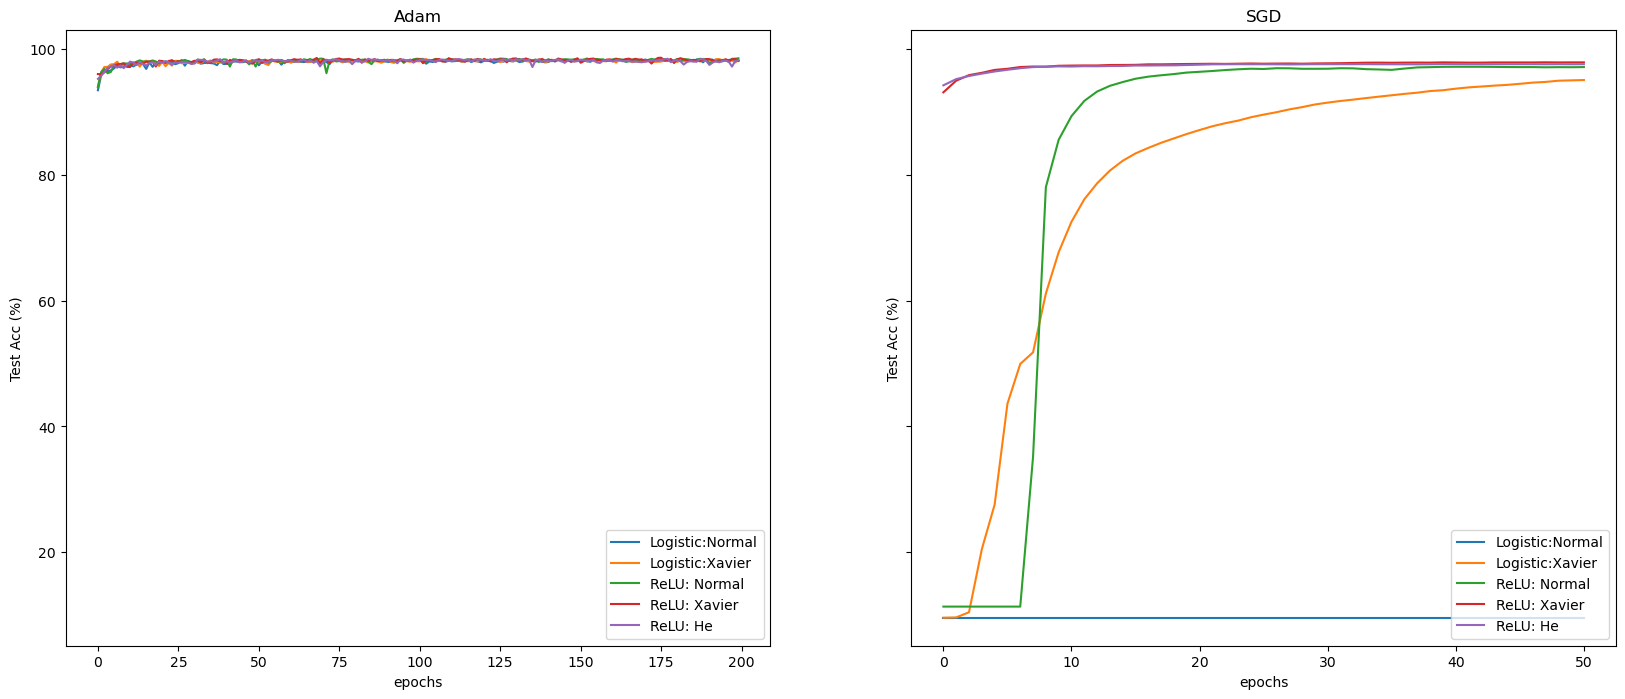

In [36]:
title = ['Adam', 'SGD']

df_sgd_50 = df_accuracy_sgd.loc[df_accuracy_sgd.index <= 50]
data = [df_accuracy_adam, df_sgd_50]

plot_2_column(data, 2, 'adam_sg.png', title)

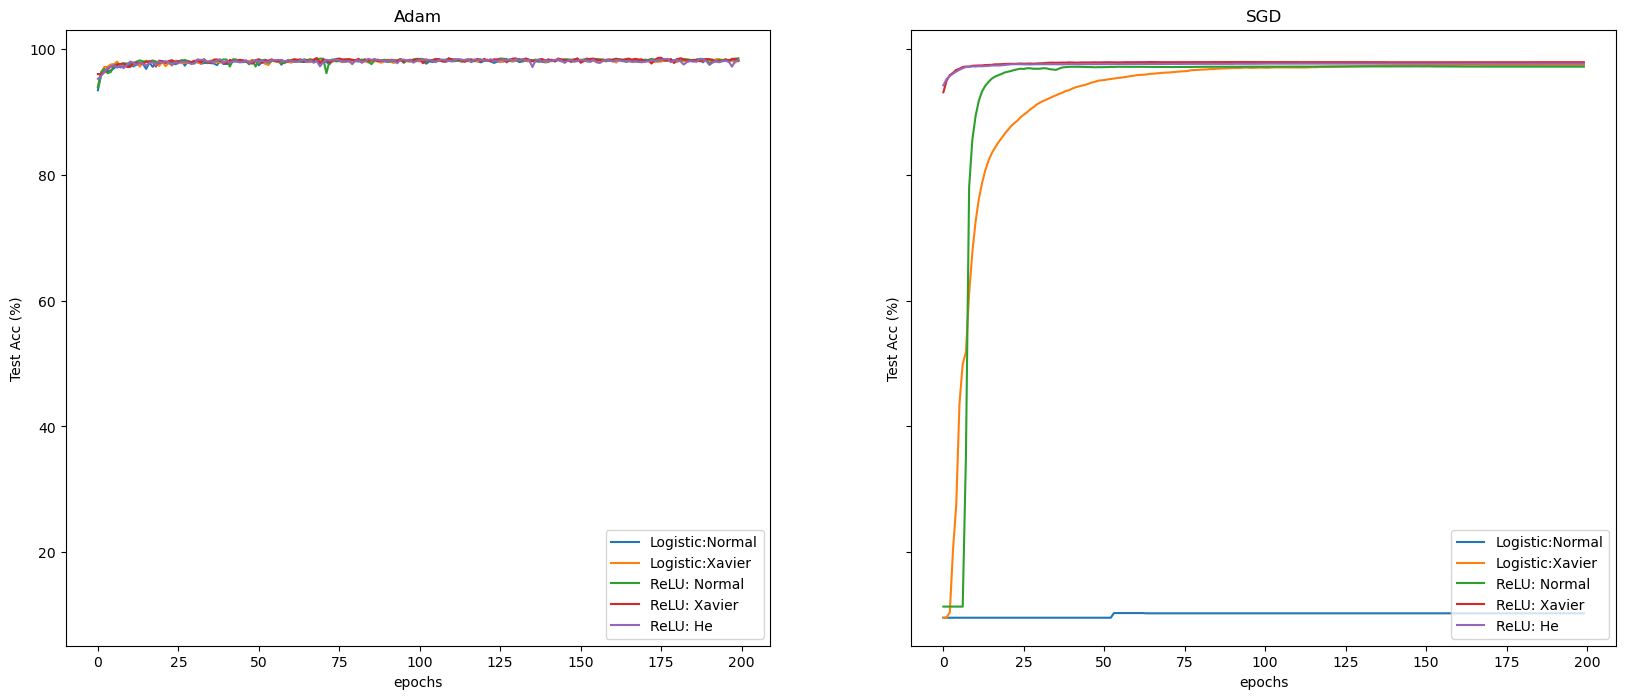

In [37]:
title = ['Adam', 'SGD']

data = [df_accuracy_adam, df_accuracy_sgd]

plot_2_column(data, 2, 'adam_sg_all.png', title, sharex=True)

In [ ]:
##Problem 3: Dropout

In [ ]:
class NeuralNetwork_Dropout(nn.Module):
    def __init__(self, type_init='Xavier', 
                 activation='sigmoid', dropout=None):
        super(NeuralNetwork_Dropout, self).__init__()

        self.type_init = type_init
        self.dropout = dropout
        self.activation = activation
        
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, 1024)
        self.l4 = nn.Linear(1024, 1024)
        self.l5 = nn.Linear(1024, 10)
        
        activation = 0
        for key, layer in self.named_children():
            if key == 'flatten':
                continue
            if self.type_init in ['Xavier']:
                nn.init.xavier_uniform_(layer.weight)
            if self.type_init in ['He']:
                nn.init.kaiming_uniform_(layer.weight)
        
    def forward(self, x):
        x = self.flatten(x)
        
        for key, layer in self.named_children():
            if (key == 'flatten'):
                continue
                
            if self.activation in ['sigmoid'] and key != 'l5':
                x = F.sigmoid(layer(x))
            if self.activation in ['ReLU'] and key != 'l5' :
                x = F.relu(layer(x))
                
            if self.dropout is not None:
                dropout = nn.Dropout(self.dropout[key])
                x = dropout(x)
            
        return x


def train_dropout(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss = train_loss + round(loss.item(), 2)
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    #Average loss over all batches
    train_loss = train_loss/len(dataloader)
    
    return round(train_loss, 2)

def test_dropout(dataloader, model, loss_fn):
    pred_y_all = torch.Tensor()
    org_y = torch.Tensor()
    input_x = torch.Tensor()
    size = len(dataloader.dataset)
    m = nn.Softmax(dim=1)
    num_batches = len(dataloader)
    
    model.eval()
    
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = m(pred)
            pred_y = pred.argmax(1)
            correct += (pred_y == y).type(torch.float).sum().item()

            pred_y_all = pred_y_all.to(device)
            pred_y_all = torch.cat((pred_y_all, pred_y))

            org_y = org_y.to(device)
            org_y = torch.cat((org_y, y))

            input_x = input_x.to(device)
            input_x = torch.cat((input_x, X))

    test_loss /= num_batches
    correct /= size
    accuracy = round(100*correct, 2)

    # print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return round(test_loss, 2)


dropout = {
    'l1': 0.2,
    'l2': 0.5,
    'l3': 0.5,
    'l4': 0.5,
    'l5': 0.5
}

total_accuracy = {
    'logistic_no_dropout': {'activation': 'sigmoid', 
                            'init': 'Xavier', 
                            'dropout': None,
                            'data': []},
    'logistic_dropout': {'activation': 'sigmoid', 
                         'init': 'Xavier', 
                         'dropout': dropout,
                         'data': []},
    'relu_no_dropout': {'activation': 'ReLU', 
                        'init': 'He', 
                        'dropout': None,
                        'data': []},
    'relu_dropout': {'activation': 'ReLU', 
                     'init': 'He', 
                     'dropout': dropout,
                     'data': []},
}

df_dropout = pd.DataFrame()
loss_fn_dropout = nn.CrossEntropyLoss()
i = True
for key in total_accuracy:
    model_dropout = NeuralNetwork_Dropout(
        total_accuracy[key]['init'],
        total_accuracy[key]['activation'],
        total_accuracy[key]['dropout']
    ).to(device)
    
    print(model_dropout.activation, model_dropout.dropout, model_dropout.type_init)
    
    optimizer_adam = torch.optim.Adam(model_dropout.parameters())
    epochs = 500

    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        loss_train = train_dropout(train_dataloader, model_dropout, loss_fn_dropout, 
            optimizer_adam)

        test_loss = test_dropout(test_dataloader, 
                           model_dropout, loss_fn_dropout)

        total_accuracy[key]['data'].append([loss_train, test_loss])
        
        # break
    columns = [f'{key}_train_loss', f'{key}_test_loss']
    
    df_temp = pd.DataFrame(data=total_accuracy[key]['data'],
                           columns=columns)
    if i == True:
        df_dropout = df_temp
        i = False
        print(df_dropout.info())
    else:
        df_dropout = pd.concat([df_dropout, df_temp], 
                               axis=1, 
                               )
        print(df_dropout.info())
    print(f"{key} Done!")

df_dropout.to_pickle('qns_3_accuracy.pkl.gz')

print('**** All done qns 3 *******')


In [38]:
df_dropout = pd.read_pickle('qns_3_accuracy.pkl.gz')

In [39]:
df_dropout.head()

,logistic_no_dropout_train_loss,logistic_no_dropout_test_loss,logistic_dropout_train_loss,logistic_dropout_test_loss,relu_no_dropout_train_loss,relu_no_dropout_test_loss,relu_dropout_train_loss,relu_dropout_test_loss
0,5.95,5.95,6.07,6.06,0.24,0.15,5.71,5.49
1,5.95,5.95,6.05,6.06,0.11,0.19,5.44,5.46
2,5.95,5.95,6.05,6.07,0.08,0.20,5.40,5.37
3,5.95,5.95,6.06,6.07,0.07,0.15,5.35,5.32
4,5.95,5.95,6.05,6.06,0.05,0.11,5.38,5.31


In [40]:
df_dropout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   logistic_no_dropout_train_loss  500 non-null    float64
 1   logistic_no_dropout_test_loss   500 non-null    float64
 2   logistic_dropout_train_loss     500 non-null    float64
 3   logistic_dropout_test_loss      500 non-null    float64
 4   relu_no_dropout_train_loss      500 non-null    float64
 5   relu_no_dropout_test_loss       500 non-null    float64
 6   relu_dropout_train_loss         500 non-null    float64
 7   relu_dropout_test_loss          500 non-null    float64
dtypes: float64(8)
memory usage: 31.4 KB


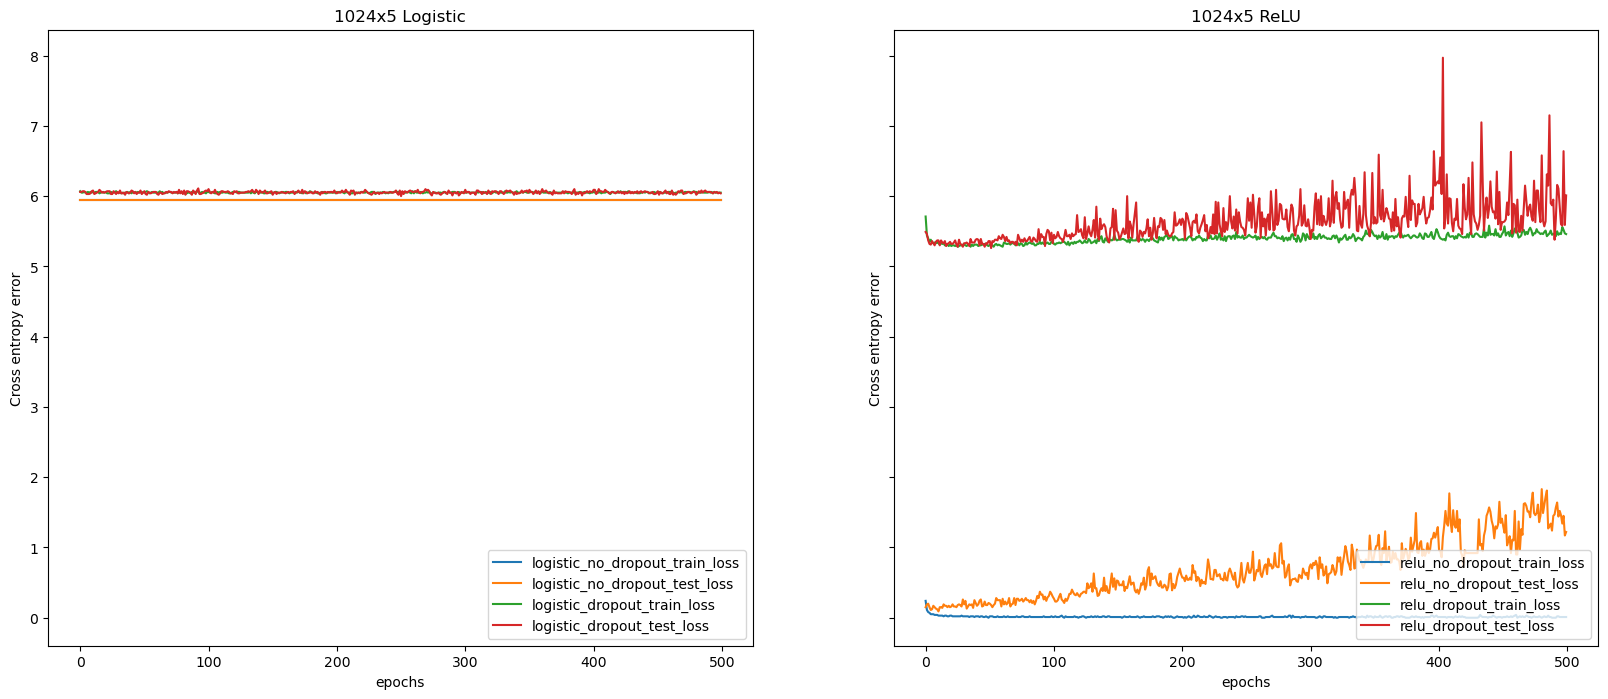

In [47]:
title = ['1024x5 Logistic', '1024x5 ReLU']



plot_2_column(df_dropout, 2, 'adam_sg.png', title, 
              sharex=True, sharey=True, break_point=True)